# Getting started

## Ensembles(3)

### Ensemble models - extended tutorial

---

> https://juliaai.github.io/DataScienceTutorials.jl/getting-started/ensembles-3/
> <br> (project folder) https://raw.githubusercontent.com/juliaai/DataScienceTutorials.jl/gh-pages/__generated/A-ensembles-3.tar.gz

> Definition of composite model type <br>
> Application to data


In [1]:
using Pkg; Pkg.activate("D:/JULIA/6_ML_with_Julia/A-ensembles-3"); Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\A-ensembles-3`


### Simple example of a homogeneous ensemble using learning networks

---

In this simple example, no bagging is used, so every atomic model gets the same learned parameters, unless the atomic model training algorithm has randomness, eg, DecisionTree with random subsampling of features at nodes.

Note that MLJ has a built in model wrapper called ```EnsembleModel``` for creating bagged ensembles with a few lines of code.

### Definition of composite model type

---

In [2]:
using MLJ
using PyPlot
import Statistics

Defining the learning network (composite model spec):

In [3]:
Xs = source()
ys = source()

DecisionTreeRegressor = @load DecisionTreeRegressor pkg = DecisionTree
atom = DecisionTreeRegressor()

machines = (machine(atom, Xs, ys) for i in 1:100)

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


Base.Generator{UnitRange{Int64}, var"#1#2"}(var"#1#2"(), 1:100)

Overloading ```mean``` for nodes:

In [4]:
Statistics.mean(v...) = mean(v)
Statistics.mean(v::AbstractVector{<:AbstractNode}) = node(mean, v...)

yhat = mean([predict(m, Xs) for m in machines]);

In [12]:
yhat

Node{Nothing}
  args:
    1:	Node{Machine{DecisionTreeRegressor,…}}
    2:	Node{Machine{DecisionTreeRegressor,…}}
    3:	Node{Machine{DecisionTreeRegressor,…}}
    4:	Node{Machine{DecisionTreeRegressor,…}}
    5:	Node{Machine{DecisionTreeRegressor,…}}
    6:	Node{Machine{DecisionTreeRegressor,…}}
    7:	Node{Machine{DecisionTreeRegressor,…}}
    8:	Node{Machine{DecisionTreeRegressor,…}}
    9:	Node{Machine{DecisionTreeRegressor,…}}
    10:	Node{Machine{DecisionTreeRegressor,…}}
    11:	Node{Machine{DecisionTreeRegressor,…}}
    12:	Node{Machine{DecisionTreeRegressor,…}}
    13:	Node{Machine{DecisionTreeRegressor,…}}
    14:	Node{Machine{DecisionTreeRegressor,…}}
    15:	Node{Machine{DecisionTreeRegressor,…}}
    16:	Node{Machine{DecisionTreeRegressor,…}}
    17:	Node{Machine{DecisionTreeRegressor,…}}
    18:	Node{Machine{DecisionTreeRegressor,…}}
    19:	Node{Machine{DecisionTreeRegressor,…}}
    20:	Node{Machine{DecisionTreeRegressor,…}}
    21:	Node{Machine{DecisionTreeRegressor,…}}


Defining the new composite model type and instance:

In [5]:
surrogate = Deterministic()
mach = machine(surrogate, Xs, ys; predict = yhat)

Machine{DeterministicSurrogate,…} trained 0 times; does not cache data
  model: DeterministicSurrogate
  args: 
    1:	Source @400 ⏎ `Nothing`
    2:	Source @782 ⏎ `Nothing`


In [6]:
@from_network mach begin
    mutable struct OneHundredModels
        atom = atom
    end
end

one_hundred_models = OneHundredModels()

OneHundredModels(
    atom = DecisionTreeRegressor(
            max_depth = -1,
            min_samples_leaf = 5,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = 0,
            post_prune = false,
            merge_purity_threshold = 1.0,
            rng = Random._GLOBAL_RNG()))

### Application to data
---

In [7]:
X, y = @load_boston;

tune regularization parameter for a single tree:

In [8]:
r = range(atom,
          :min_samples_split,
          lower = 2, 
          upper = 100, 
          scale = :log)

mach = machine(atom, X, y)

Machine{DecisionTreeRegressor,…} trained 0 times; caches data
  model: MLJDecisionTreeInterface.DecisionTreeRegressor
  args: 
    1:	Source @993 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @007 ⏎ `AbstractVector{Continuous}`


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\jeffr\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


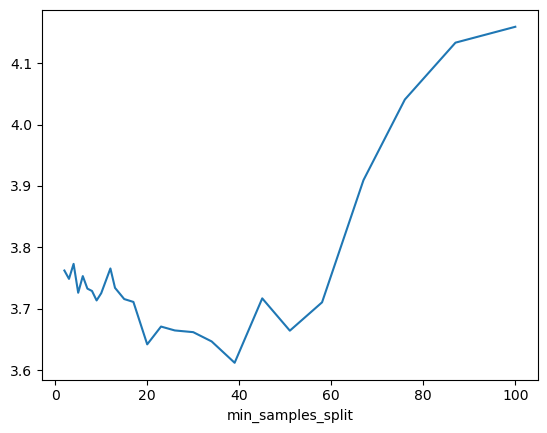

In [9]:
figure()
curve = learning_curve!(mach, 
                        range = r,
                        measure = mav, 
                        resampling = CV(nfolds = 9),
                        verbosity = 0)

plot(curve.parameter_values, curve.measurements)
xlabel(curve.parameter_name)
savefig("./plots/2.6.1.png")

tune regularization parameter for all trees in ensemble simultaneously:

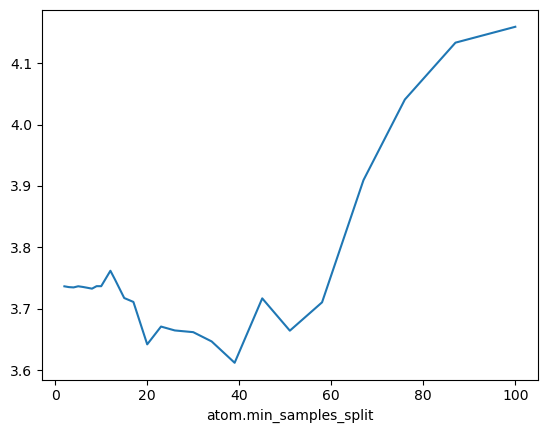

In [10]:
r = range(one_hundred_models,
          :(atom.min_samples_split),
          lower = 2, 
          upper = 100,
          scale =:log)

mach = machine(one_hundred_models, X, y)

figure()
curve = learning_curve!(mach, 
                        range = r,
                        measure = mav,
                        resampling = CV(nfolds = 9),
                        verbosity = 0)

plot(curve.parameter_values, curve.measurements)
xlabel(curve.parameter_name)
savefig("./plots/2.6.2.png")